In [3]:
import torch
import torch.nn.functional as F
import sys
try: # whether we're on titanic or not work on my regression_classif branch at least.
    sys.path.append("/home/mathieu/local/py_script/dnadna")
    import net as net_module
except ModuleNotFoundError:
    #sys.path.append("/home/jean/Documents/ML_genetics/dnadna/")
    #import net as net_module
    print("import fail")
import numpy as np
import pandas as pd
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
dfparam = pd.read_csv('/media/mathieu/crucialmx300/exp/BacterialDemoSelection_param', sep="\t", header=0)
def compute_expected_class(scenario_name):
    expected_class = 1
    model_init = dfparam.at[int(scenario_name[9:]),'model_init']
    demo=""
    if 'Bottleneck' in model_init :
        expected_class = 0
        demo = "Bot"
    if 'Constant' in model_init :
        expected_class = 1
        demo="Cst"
    if 'Expansion' in model_init :
        expected_class = 2
        demo="Exp"
    selection = dfparam.at[int(scenario_name[9:]),'selection']
    return expected_class, demo, selection

In [5]:
#After gargammel result are in different repertories
#Repertories have different names depending which parameter have been used
#This function use the name of the repertorie to extract parameters value

def translate_real_param(dirname):
    realparam = dirname.replace('_', ' ').replace('t','-')
    params = realparam.split(',')
    coverage = params[0].split(' ')[1]
    if len(params) > 1:
        sequencing_error_param = params[1].split(' ')[1]
        sequencing_error = math.ceil(0.1 * 1/(pow(10,(int(sequencing_error_param)/10))))
    else:
        sequencing_error = 0.1
    return coverage, sequencing_error

In [6]:
#/home/tau/jcury/DLDATA/BacterialDemoSelection/run_012/BacterialDemoSelection_run_012_net.pth
#initiate network
device = torch.device('cuda' if torch.cuda.is_available() 
                      else 'cpu') # with or without gpu
net3 = net_module.CNN3(3)
net3.eval(); # to deactivate dropout and batchnorm
weight3 = torch.load("/media/mathieu/crucialmx300/skyline/BacterialDemoSelection_run_012_net.pth",
                     map_location=device,
                    )
from collections import OrderedDict
new_state_dict3 = OrderedDict()
for (k, v), k2 in zip(weight3.items(), net3.state_dict().keys()):
    if k.strip("module.") in k2:
        new_state_dict3[k2] = v
    else:
        print(k, k2)
net3.load_state_dict(new_state_dict3, strict=True) 
sm = torch.nn.Softmax(dim=1)

In [127]:
originalDatapath = "/media/mathieu/crucialmx300/skyline/20"
#initiate result dataframe
dfres = pd.DataFrame(columns=['scenario','replicate','damage','coverage','error_rate','expected_class', \
                              'observed_class', 'softmax_for_observed_class','nb_SNP','demo','selection'])

i=0
for scenario in os.listdir(originalDatapath):
    scenardir = originalDatapath +'/'+ scenario
    for replicate in os.listdir(scenardir):
        replicatepath = scenardir + '/' + replicate

        try :
            expected_class, demo, selection = compute_expected_class(scenario)
            
            #compute prediction
            data_snp = np.load(replicatepath)
            snp, pos = data_snp["SNP"], data_snp["POS"]
            matrixLength = snp.shape[1]
            data_in = torch.cat((torch.Tensor(snp), torch.Tensor(pos).unsqueeze(0))).unsqueeze(0)

            output = net3(data_in)

            val, predicted_class = torch.max(output, 1)

            predicted_class_int = predicted_class.item()               
            softmax = sm(output)
            listsm = softmax.tolist()

            #create new line for each replicate
            dfres.loc[i] = [scenario, replicate, 0, 0, 0, expected_class , predicted_class_int, listsm , matrixLength, demo, selection]
            i += 1

        except RuntimeError:
            #not enough positions ?
            print("error computing prediction for " + scenario + ':' + replicate + ': nbSNP=' + str(matrixLength))

dforiginal = dfres

error computing prediction for scenario_00032:BacterialDemoSelection_00032_012.npz: nbSNP=110
error computing prediction for scenario_00032:BacterialDemoSelection_00032_020.npz: nbSNP=72
error computing prediction for scenario_00032:BacterialDemoSelection_00032_026.npz: nbSNP=74
error computing prediction for scenario_00032:BacterialDemoSelection_00032_034.npz: nbSNP=56
error computing prediction for scenario_00032:BacterialDemoSelection_00032_035.npz: nbSNP=66
error computing prediction for scenario_00032:BacterialDemoSelection_00032_076.npz: nbSNP=55
error computing prediction for scenario_00919:BacterialDemoSelection_00919_009.npz: nbSNP=81
error computing prediction for scenario_00919:BacterialDemoSelection_00919_013.npz: nbSNP=85
error computing prediction for scenario_00919:BacterialDemoSelection_00919_024.npz: nbSNP=66
error computing prediction for scenario_00919:BacterialDemoSelection_00919_031.npz: nbSNP=26
error computing prediction for scenario_00919:BacterialDemoSelection_

error computing prediction for scenario_05859:BacterialDemoSelection_05859_085.npz: nbSNP=71
error computing prediction for scenario_05859:BacterialDemoSelection_05859_089.npz: nbSNP=53
error computing prediction for scenario_05887:BacterialDemoSelection_05887_000.npz: nbSNP=74
error computing prediction for scenario_05887:BacterialDemoSelection_05887_006.npz: nbSNP=87
error computing prediction for scenario_05887:BacterialDemoSelection_05887_007.npz: nbSNP=93
error computing prediction for scenario_05887:BacterialDemoSelection_05887_015.npz: nbSNP=109
error computing prediction for scenario_05887:BacterialDemoSelection_05887_018.npz: nbSNP=75
error computing prediction for scenario_05887:BacterialDemoSelection_05887_031.npz: nbSNP=102
error computing prediction for scenario_05887:BacterialDemoSelection_05887_033.npz: nbSNP=78
error computing prediction for scenario_05887:BacterialDemoSelection_05887_049.npz: nbSNP=93
error computing prediction for scenario_05887:BacterialDemoSelection

error computing prediction for scenario_02107:BacterialDemoSelection_02107_083.npz: nbSNP=43
error computing prediction for scenario_02107:BacterialDemoSelection_02107_098.npz: nbSNP=110
error computing prediction for scenario_02191:BacterialDemoSelection_02191_015.npz: nbSNP=81
error computing prediction for scenario_02191:BacterialDemoSelection_02191_047.npz: nbSNP=137
error computing prediction for scenario_02191:BacterialDemoSelection_02191_078.npz: nbSNP=60
error computing prediction for scenario_02191:BacterialDemoSelection_02191_079.npz: nbSNP=135
error computing prediction for scenario_02191:BacterialDemoSelection_02191_098.npz: nbSNP=82
error computing prediction for scenario_02576:BacterialDemoSelection_02576_004.npz: nbSNP=132
error computing prediction for scenario_02576:BacterialDemoSelection_02576_033.npz: nbSNP=90
error computing prediction for scenario_02576:BacterialDemoSelection_02576_055.npz: nbSNP=119
error computing prediction for scenario_02576:BacterialDemoSelect

error computing prediction for scenario_03047:BacterialDemoSelection_03047_087.npz: nbSNP=59
error computing prediction for scenario_03049:BacterialDemoSelection_03049_009.npz: nbSNP=120
error computing prediction for scenario_03049:BacterialDemoSelection_03049_013.npz: nbSNP=90
error computing prediction for scenario_03049:BacterialDemoSelection_03049_021.npz: nbSNP=133
error computing prediction for scenario_03049:BacterialDemoSelection_03049_030.npz: nbSNP=84
error computing prediction for scenario_03049:BacterialDemoSelection_03049_053.npz: nbSNP=97
error computing prediction for scenario_03049:BacterialDemoSelection_03049_055.npz: nbSNP=108
error computing prediction for scenario_03049:BacterialDemoSelection_03049_057.npz: nbSNP=88
error computing prediction for scenario_03049:BacterialDemoSelection_03049_083.npz: nbSNP=93
error computing prediction for scenario_03049:BacterialDemoSelection_03049_085.npz: nbSNP=117
error computing prediction for scenario_03175:BacterialDemoSelecti

error computing prediction for scenario_03815:BacterialDemoSelection_03815_086.npz: nbSNP=90
error computing prediction for scenario_03853:BacterialDemoSelection_03853_004.npz: nbSNP=70
error computing prediction for scenario_03853:BacterialDemoSelection_03853_013.npz: nbSNP=72
error computing prediction for scenario_03853:BacterialDemoSelection_03853_019.npz: nbSNP=93
error computing prediction for scenario_03853:BacterialDemoSelection_03853_056.npz: nbSNP=38
error computing prediction for scenario_03853:BacterialDemoSelection_03853_060.npz: nbSNP=71
error computing prediction for scenario_03853:BacterialDemoSelection_03853_061.npz: nbSNP=96
error computing prediction for scenario_03853:BacterialDemoSelection_03853_074.npz: nbSNP=87
error computing prediction for scenario_03853:BacterialDemoSelection_03853_075.npz: nbSNP=109
error computing prediction for scenario_03853:BacterialDemoSelection_03853_096.npz: nbSNP=65
error computing prediction for scenario_03853:BacterialDemoSelection_

error computing prediction for scenario_04721:BacterialDemoSelection_04721_098.npz: nbSNP=21
error computing prediction for scenario_04859:BacterialDemoSelection_04859_006.npz: nbSNP=40
error computing prediction for scenario_04859:BacterialDemoSelection_04859_019.npz: nbSNP=42
error computing prediction for scenario_04859:BacterialDemoSelection_04859_020.npz: nbSNP=38
error computing prediction for scenario_04859:BacterialDemoSelection_04859_030.npz: nbSNP=40
error computing prediction for scenario_04859:BacterialDemoSelection_04859_045.npz: nbSNP=40
error computing prediction for scenario_04859:BacterialDemoSelection_04859_048.npz: nbSNP=44
error computing prediction for scenario_04859:BacterialDemoSelection_04859_075.npz: nbSNP=46
error computing prediction for scenario_04859:BacterialDemoSelection_04859_076.npz: nbSNP=38
error computing prediction for scenario_04859:BacterialDemoSelection_04859_080.npz: nbSNP=39
error computing prediction for scenario_04859:BacterialDemoSelection_0

error computing prediction for scenario_10099:BacterialDemoSelection_10099_084.npz: nbSNP=33
error computing prediction for scenario_10099:BacterialDemoSelection_10099_089.npz: nbSNP=40
error computing prediction for scenario_10227:BacterialDemoSelection_10227_003.npz: nbSNP=71
error computing prediction for scenario_10227:BacterialDemoSelection_10227_007.npz: nbSNP=56
error computing prediction for scenario_10227:BacterialDemoSelection_10227_013.npz: nbSNP=81
error computing prediction for scenario_10227:BacterialDemoSelection_10227_025.npz: nbSNP=60
error computing prediction for scenario_10227:BacterialDemoSelection_10227_039.npz: nbSNP=56
error computing prediction for scenario_10227:BacterialDemoSelection_10227_042.npz: nbSNP=56
error computing prediction for scenario_10227:BacterialDemoSelection_10227_062.npz: nbSNP=57
error computing prediction for scenario_10227:BacterialDemoSelection_10227_079.npz: nbSNP=92
error computing prediction for scenario_10227:BacterialDemoSelection_1

In [138]:
postGargapath = "/media/mathieu/crucialmx300/exp/newresult/damage"
i=0
#initiate result dataframe
dfres = pd.DataFrame(columns=['scenario','replicate','damage','coverage','error_rate','expected_class', \
                              'observed_class', 'softmax_for_observed_class','nb_SNP','demo','selection'])
for degree in os.listdir(postGargapath):
    degreepath = postGargapath + '/' + degree
    if os.path.isdir(degreepath) :
        for param in os.listdir(degreepath):
            coverage, sequencing_error = translate_real_param(param)
            parampath = degreepath + '/' + param        
            for scenario in os.listdir(parampath):
                scenariopath =  parampath +'/'+ scenario
                for replicate in os.listdir(scenariopath):
                    replicatepath = scenariopath + '/' + replicate

                    
                    try :
                        
                        expected_class, demo, selection = compute_expected_class(scenario)

                        #compute prediction
                        data_snp = np.load(replicatepath)
                        snp, pos = data_snp["SNP"], data_snp["POS"]
                        matrixLength = snp.shape[1]
                        data_in = torch.cat((torch.Tensor(snp), torch.Tensor(pos).unsqueeze(0))).unsqueeze(0)

                        output = net3(data_in)

                        val, predicted_class = torch.max(output, 1)

                        predicted_class_int = predicted_class.item()               
                        softmax = sm(output)
                        listsm = softmax.tolist()
                        
                        #create new line for each replicate
                        dfres.loc[i] = [scenario, replicate[1:], degree, float(coverage), sequencing_error, expected_class , predicted_class_int, listsm , matrixLength, demo, selection]
                        i += 1
            
                    except RuntimeError:
                        #not enough positions ?
                        print("error computing prediction for " + degree + ':' + ' c=' + str(coverage) + ', Erate=' + str(sequencing_error) + \
                              '% :' + scenario + ':' + replicate[1:])
                    except IndexError:
                        print(degree + ':' + ' c=' + str(coverage) + ', Erate=' + str(sequencing_error)+ scenario + ':' + replicate[1:] + " was not found")



error computing prediction for med: c=4, Erate=1% :scenario_09013:BacterialDemoSelection_09013_033.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_00032:BacterialDemoSelection_00032_011.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_00032:BacterialDemoSelection_00032_012.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_00032:BacterialDemoSelection_00032_020.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_00032:BacterialDemoSelection_00032_026.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_00032:BacterialDemoSelection_00032_034.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_00032:BacterialDemoSelection_00032_035.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_00032:BacterialDemoSelection_00032_038.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_00032:BacterialDemoSelection_00032_067.npz
error computing prediction for none: c=1, Erate=0

error computing prediction for none: c=1, Erate=0.1% :scenario_02576:BacterialDemoSelection_02576_079.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_02576:BacterialDemoSelection_02576_089.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_02586:BacterialDemoSelection_02586_003.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_02586:BacterialDemoSelection_02586_028.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_02586:BacterialDemoSelection_02586_041.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_02586:BacterialDemoSelection_02586_067.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_02586:BacterialDemoSelection_02586_073.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_02586:BacterialDemoSelection_02586_093.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_02617:BacterialDemoSelection_02617_010.npz
error computing prediction for none: c=1, Erat

error computing prediction for none: c=1, Erate=0.1% :scenario_02816:BacterialDemoSelection_02816_057.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_02816:BacterialDemoSelection_02816_058.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_02816:BacterialDemoSelection_02816_079.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_02816:BacterialDemoSelection_02816_082.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_02816:BacterialDemoSelection_02816_092.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04612:BacterialDemoSelection_04612_003.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04612:BacterialDemoSelection_04612_004.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04612:BacterialDemoSelection_04612_022.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04612:BacterialDemoSelection_04612_040.npz
error computing prediction for none: c=1, Erat

error computing prediction for none: c=1, Erate=0.1% :scenario_04955:BacterialDemoSelection_04955_085.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_06263:BacterialDemoSelection_06263_001.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_06263:BacterialDemoSelection_06263_011.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_06263:BacterialDemoSelection_06263_013.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_06263:BacterialDemoSelection_06263_031.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_06263:BacterialDemoSelection_06263_038.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_06263:BacterialDemoSelection_06263_045.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_06263:BacterialDemoSelection_06263_065.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_06263:BacterialDemoSelection_06263_066.npz
error computing prediction for none: c=1, Erat

error computing prediction for none: c=1, Erate=0.1% :scenario_09524:BacterialDemoSelection_09524_033.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_09524:BacterialDemoSelection_09524_045.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_09524:BacterialDemoSelection_09524_046.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_09524:BacterialDemoSelection_09524_052.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_09524:BacterialDemoSelection_09524_082.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_09533:BacterialDemoSelection_09533_003.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_09533:BacterialDemoSelection_09533_007.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_09533:BacterialDemoSelection_09533_013.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_09533:BacterialDemoSelection_09533_019.npz
error computing prediction for none: c=1, Erat

error computing prediction for none: c=1, Erate=0.1% :scenario_09789:BacterialDemoSelection_09789_092.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_09789:BacterialDemoSelection_09789_099.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_09831:BacterialDemoSelection_09831_012.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_09831:BacterialDemoSelection_09831_018.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_09831:BacterialDemoSelection_09831_022.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_09831:BacterialDemoSelection_09831_061.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_09831:BacterialDemoSelection_09831_064.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_09831:BacterialDemoSelection_09831_065.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_09831:BacterialDemoSelection_09831_073.npz
error computing prediction for none: c=1, Erat

error computing prediction for none: c=1, Erate=0.1% :scenario_03041:BacterialDemoSelection_03041_002.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03041:BacterialDemoSelection_03041_015.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03041:BacterialDemoSelection_03041_022.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03041:BacterialDemoSelection_03041_026.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03041:BacterialDemoSelection_03041_039.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03041:BacterialDemoSelection_03041_050.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03041:BacterialDemoSelection_03041_057.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03041:BacterialDemoSelection_03041_058.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03041:BacterialDemoSelection_03041_086.npz
error computing prediction for none: c=1, Erat

error computing prediction for none: c=1, Erate=0.1% :scenario_03262:BacterialDemoSelection_03262_049.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03262:BacterialDemoSelection_03262_058.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03262:BacterialDemoSelection_03262_071.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03262:BacterialDemoSelection_03262_080.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03262:BacterialDemoSelection_03262_098.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03266:BacterialDemoSelection_03266_020.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03266:BacterialDemoSelection_03266_030.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03266:BacterialDemoSelection_03266_036.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03266:BacterialDemoSelection_03266_048.npz
error computing prediction for none: c=1, Erat

error computing prediction for none: c=1, Erate=0.1% :scenario_03434:BacterialDemoSelection_03434_057.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03434:BacterialDemoSelection_03434_062.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03438:BacterialDemoSelection_03438_021.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03438:BacterialDemoSelection_03438_023.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03438:BacterialDemoSelection_03438_043.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03438:BacterialDemoSelection_03438_050.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03438:BacterialDemoSelection_03438_055.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03438:BacterialDemoSelection_03438_056.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03438:BacterialDemoSelection_03438_068.npz
error computing prediction for none: c=1, Erat

error computing prediction for none: c=1, Erate=0.1% :scenario_03692:BacterialDemoSelection_03692_069.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03692:BacterialDemoSelection_03692_071.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03692:BacterialDemoSelection_03692_074.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03692:BacterialDemoSelection_03692_081.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03692:BacterialDemoSelection_03692_087.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03692:BacterialDemoSelection_03692_092.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03729:BacterialDemoSelection_03729_008.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03729:BacterialDemoSelection_03729_028.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_03729:BacterialDemoSelection_03729_031.npz
error computing prediction for none: c=1, Erat

error computing prediction for none: c=1, Erate=0.1% :scenario_04172:BacterialDemoSelection_04172_015.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04172:BacterialDemoSelection_04172_016.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04172:BacterialDemoSelection_04172_037.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04172:BacterialDemoSelection_04172_044.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04172:BacterialDemoSelection_04172_077.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04172:BacterialDemoSelection_04172_089.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04172:BacterialDemoSelection_04172_093.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04172:BacterialDemoSelection_04172_095.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04172:BacterialDemoSelection_04172_099.npz
error computing prediction for none: c=1, Erat

error computing prediction for none: c=1, Erate=0.1% :scenario_04384:BacterialDemoSelection_04384_091.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04384:BacterialDemoSelection_04384_096.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04402:BacterialDemoSelection_04402_015.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04402:BacterialDemoSelection_04402_021.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04402:BacterialDemoSelection_04402_027.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04402:BacterialDemoSelection_04402_045.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04402:BacterialDemoSelection_04402_051.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04402:BacterialDemoSelection_04402_057.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_04402:BacterialDemoSelection_04402_063.npz
error computing prediction for none: c=1, Erat

error computing prediction for none: c=1, Erate=0.1% :scenario_10368:BacterialDemoSelection_10368_083.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_10368:BacterialDemoSelection_10368_090.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_10395:BacterialDemoSelection_10395_000.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_10395:BacterialDemoSelection_10395_033.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_10395:BacterialDemoSelection_10395_036.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_10395:BacterialDemoSelection_10395_037.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_10395:BacterialDemoSelection_10395_046.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_10395:BacterialDemoSelection_10395_053.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_10395:BacterialDemoSelection_10395_054.npz
error computing prediction for none: c=1, Erat

error computing prediction for none: c=1, Erate=0.1% :scenario_10643:BacterialDemoSelection_10643_078.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_10643:BacterialDemoSelection_10643_080.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_10648:BacterialDemoSelection_10648_009.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_10648:BacterialDemoSelection_10648_028.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_10648:BacterialDemoSelection_10648_046.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_10648:BacterialDemoSelection_10648_048.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_10648:BacterialDemoSelection_10648_057.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_10648:BacterialDemoSelection_10648_066.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_10648:BacterialDemoSelection_10648_069.npz
error computing prediction for none: c=1, Erat

error computing prediction for none: c=1, Erate=0.1% :scenario_08622:BacterialDemoSelection_08622_063.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_08622:BacterialDemoSelection_08622_078.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_08622:BacterialDemoSelection_08622_084.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_08622:BacterialDemoSelection_08622_091.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_08663:BacterialDemoSelection_08663_007.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_08663:BacterialDemoSelection_08663_009.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_08663:BacterialDemoSelection_08663_011.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_08663:BacterialDemoSelection_08663_020.npz
error computing prediction for none: c=1, Erate=0.1% :scenario_08663:BacterialDemoSelection_08663_059.npz
error computing prediction for none: c=1, Erat

error computing prediction for none: c=1, Erate=1% :scenario_00032:BacterialDemoSelection_00032_076.npz
error computing prediction for none: c=1, Erate=1% :scenario_00032:BacterialDemoSelection_00032_077.npz
error computing prediction for none: c=1, Erate=1% :scenario_00919:BacterialDemoSelection_00919_009.npz
error computing prediction for none: c=1, Erate=1% :scenario_00919:BacterialDemoSelection_00919_013.npz
error computing prediction for none: c=1, Erate=1% :scenario_00919:BacterialDemoSelection_00919_024.npz
error computing prediction for none: c=1, Erate=1% :scenario_00919:BacterialDemoSelection_00919_031.npz
error computing prediction for none: c=1, Erate=1% :scenario_00919:BacterialDemoSelection_00919_044.npz
error computing prediction for none: c=1, Erate=1% :scenario_00919:BacterialDemoSelection_00919_056.npz
error computing prediction for none: c=1, Erate=1% :scenario_00919:BacterialDemoSelection_00919_075.npz
error computing prediction for none: c=1, Erate=1% :scenario_009

error computing prediction for none: c=1, Erate=1% :scenario_02586:BacterialDemoSelection_02586_041.npz
error computing prediction for none: c=1, Erate=1% :scenario_02586:BacterialDemoSelection_02586_067.npz
error computing prediction for none: c=1, Erate=1% :scenario_02586:BacterialDemoSelection_02586_073.npz
error computing prediction for none: c=1, Erate=1% :scenario_02586:BacterialDemoSelection_02586_079.npz
error computing prediction for none: c=1, Erate=1% :scenario_02586:BacterialDemoSelection_02586_093.npz
error computing prediction for none: c=1, Erate=1% :scenario_02617:BacterialDemoSelection_02617_010.npz
error computing prediction for none: c=1, Erate=1% :scenario_02617:BacterialDemoSelection_02617_016.npz
error computing prediction for none: c=1, Erate=1% :scenario_02617:BacterialDemoSelection_02617_021.npz
error computing prediction for none: c=1, Erate=1% :scenario_02617:BacterialDemoSelection_02617_029.npz
error computing prediction for none: c=1, Erate=1% :scenario_026

error computing prediction for none: c=1, Erate=1% :scenario_02816:BacterialDemoSelection_02816_082.npz
error computing prediction for none: c=1, Erate=1% :scenario_02816:BacterialDemoSelection_02816_092.npz
error computing prediction for none: c=1, Erate=1% :scenario_02816:BacterialDemoSelection_02816_094.npz
error computing prediction for none: c=1, Erate=1% :scenario_04612:BacterialDemoSelection_04612_003.npz
error computing prediction for none: c=1, Erate=1% :scenario_04612:BacterialDemoSelection_04612_004.npz
error computing prediction for none: c=1, Erate=1% :scenario_04612:BacterialDemoSelection_04612_022.npz
error computing prediction for none: c=1, Erate=1% :scenario_04612:BacterialDemoSelection_04612_040.npz
error computing prediction for none: c=1, Erate=1% :scenario_04612:BacterialDemoSelection_04612_061.npz
error computing prediction for none: c=1, Erate=1% :scenario_04612:BacterialDemoSelection_04612_072.npz
error computing prediction for none: c=1, Erate=1% :scenario_046

error computing prediction for none: c=1, Erate=1% :scenario_04955:BacterialDemoSelection_04955_085.npz
error computing prediction for none: c=1, Erate=1% :scenario_06263:BacterialDemoSelection_06263_001.npz
error computing prediction for none: c=1, Erate=1% :scenario_06263:BacterialDemoSelection_06263_011.npz
error computing prediction for none: c=1, Erate=1% :scenario_06263:BacterialDemoSelection_06263_013.npz
error computing prediction for none: c=1, Erate=1% :scenario_06263:BacterialDemoSelection_06263_031.npz
error computing prediction for none: c=1, Erate=1% :scenario_06263:BacterialDemoSelection_06263_038.npz
error computing prediction for none: c=1, Erate=1% :scenario_06263:BacterialDemoSelection_06263_045.npz
error computing prediction for none: c=1, Erate=1% :scenario_06263:BacterialDemoSelection_06263_065.npz
error computing prediction for none: c=1, Erate=1% :scenario_06263:BacterialDemoSelection_06263_066.npz
error computing prediction for none: c=1, Erate=1% :scenario_062

error computing prediction for none: c=1, Erate=1% :scenario_09365:BacterialDemoSelection_09365_077.npz
error computing prediction for none: c=1, Erate=1% :scenario_09365:BacterialDemoSelection_09365_090.npz
error computing prediction for none: c=1, Erate=1% :scenario_09365:BacterialDemoSelection_09365_092.npz
error computing prediction for none: c=1, Erate=1% :scenario_09365:BacterialDemoSelection_09365_093.npz
error computing prediction for none: c=1, Erate=1% :scenario_09496:BacterialDemoSelection_09496_005.npz
error computing prediction for none: c=1, Erate=1% :scenario_09496:BacterialDemoSelection_09496_007.npz
error computing prediction for none: c=1, Erate=1% :scenario_09496:BacterialDemoSelection_09496_021.npz
error computing prediction for none: c=1, Erate=1% :scenario_09496:BacterialDemoSelection_09496_054.npz
error computing prediction for none: c=1, Erate=1% :scenario_09496:BacterialDemoSelection_09496_068.npz
error computing prediction for none: c=1, Erate=1% :scenario_094

error computing prediction for none: c=1, Erate=1% :scenario_09759:BacterialDemoSelection_09759_040.npz
error computing prediction for none: c=1, Erate=1% :scenario_09759:BacterialDemoSelection_09759_064.npz
error computing prediction for none: c=1, Erate=1% :scenario_09759:BacterialDemoSelection_09759_065.npz
error computing prediction for none: c=1, Erate=1% :scenario_09759:BacterialDemoSelection_09759_071.npz
error computing prediction for none: c=1, Erate=1% :scenario_09759:BacterialDemoSelection_09759_076.npz
error computing prediction for none: c=1, Erate=1% :scenario_09759:BacterialDemoSelection_09759_095.npz
error computing prediction for none: c=1, Erate=1% :scenario_09764:BacterialDemoSelection_09764_004.npz
error computing prediction for none: c=1, Erate=1% :scenario_09764:BacterialDemoSelection_09764_014.npz
error computing prediction for none: c=1, Erate=1% :scenario_09764:BacterialDemoSelection_09764_019.npz
error computing prediction for none: c=1, Erate=1% :scenario_097

error computing prediction for none: c=1, Erate=1% :scenario_10099:BacterialDemoSelection_10099_084.npz
error computing prediction for none: c=1, Erate=1% :scenario_10099:BacterialDemoSelection_10099_089.npz
error computing prediction for none: c=1, Erate=1% :scenario_02908:BacterialDemoSelection_02908_012.npz
error computing prediction for none: c=1, Erate=1% :scenario_02908:BacterialDemoSelection_02908_070.npz
error computing prediction for none: c=1, Erate=1% :scenario_02994:BacterialDemoSelection_02994_007.npz
error computing prediction for none: c=1, Erate=1% :scenario_02994:BacterialDemoSelection_02994_009.npz
error computing prediction for none: c=1, Erate=1% :scenario_02994:BacterialDemoSelection_02994_015.npz
error computing prediction for none: c=1, Erate=1% :scenario_02994:BacterialDemoSelection_02994_020.npz
error computing prediction for none: c=1, Erate=1% :scenario_02994:BacterialDemoSelection_02994_025.npz
error computing prediction for none: c=1, Erate=1% :scenario_029

error computing prediction for none: c=1, Erate=1% :scenario_03175:BacterialDemoSelection_03175_036.npz
error computing prediction for none: c=1, Erate=1% :scenario_03175:BacterialDemoSelection_03175_038.npz
error computing prediction for none: c=1, Erate=1% :scenario_03175:BacterialDemoSelection_03175_046.npz
error computing prediction for none: c=1, Erate=1% :scenario_03175:BacterialDemoSelection_03175_051.npz
error computing prediction for none: c=1, Erate=1% :scenario_03175:BacterialDemoSelection_03175_060.npz
error computing prediction for none: c=1, Erate=1% :scenario_03175:BacterialDemoSelection_03175_063.npz
error computing prediction for none: c=1, Erate=1% :scenario_03175:BacterialDemoSelection_03175_084.npz
error computing prediction for none: c=1, Erate=1% :scenario_03175:BacterialDemoSelection_03175_088.npz
error computing prediction for none: c=1, Erate=1% :scenario_03203:BacterialDemoSelection_03203_008.npz
error computing prediction for none: c=1, Erate=1% :scenario_032

error computing prediction for none: c=1, Erate=1% :scenario_03323:BacterialDemoSelection_03323_022.npz
error computing prediction for none: c=1, Erate=1% :scenario_03323:BacterialDemoSelection_03323_046.npz
error computing prediction for none: c=1, Erate=1% :scenario_03323:BacterialDemoSelection_03323_051.npz
error computing prediction for none: c=1, Erate=1% :scenario_03323:BacterialDemoSelection_03323_058.npz
error computing prediction for none: c=1, Erate=1% :scenario_03323:BacterialDemoSelection_03323_066.npz
error computing prediction for none: c=1, Erate=1% :scenario_03323:BacterialDemoSelection_03323_070.npz
error computing prediction for none: c=1, Erate=1% :scenario_03323:BacterialDemoSelection_03323_086.npz
error computing prediction for none: c=1, Erate=1% :scenario_03323:BacterialDemoSelection_03323_089.npz
error computing prediction for none: c=1, Erate=1% :scenario_03335:BacterialDemoSelection_03335_007.npz
error computing prediction for none: c=1, Erate=1% :scenario_033

error computing prediction for none: c=1, Erate=1% :scenario_03498:BacterialDemoSelection_03498_079.npz
error computing prediction for none: c=1, Erate=1% :scenario_03529:BacterialDemoSelection_03529_001.npz
error computing prediction for none: c=1, Erate=1% :scenario_03529:BacterialDemoSelection_03529_005.npz
error computing prediction for none: c=1, Erate=1% :scenario_03529:BacterialDemoSelection_03529_027.npz
error computing prediction for none: c=1, Erate=1% :scenario_03529:BacterialDemoSelection_03529_033.npz
error computing prediction for none: c=1, Erate=1% :scenario_03529:BacterialDemoSelection_03529_036.npz
error computing prediction for none: c=1, Erate=1% :scenario_03529:BacterialDemoSelection_03529_046.npz
error computing prediction for none: c=1, Erate=1% :scenario_03529:BacterialDemoSelection_03529_049.npz
error computing prediction for none: c=1, Erate=1% :scenario_03529:BacterialDemoSelection_03529_063.npz
error computing prediction for none: c=1, Erate=1% :scenario_035

error computing prediction for none: c=1, Erate=1% :scenario_03729:BacterialDemoSelection_03729_079.npz
error computing prediction for none: c=1, Erate=1% :scenario_03729:BacterialDemoSelection_03729_088.npz
error computing prediction for none: c=1, Erate=1% :scenario_03729:BacterialDemoSelection_03729_089.npz
error computing prediction for none: c=1, Erate=1% :scenario_03729:BacterialDemoSelection_03729_090.npz
error computing prediction for none: c=1, Erate=1% :scenario_03815:BacterialDemoSelection_03815_005.npz
error computing prediction for none: c=1, Erate=1% :scenario_03815:BacterialDemoSelection_03815_010.npz
error computing prediction for none: c=1, Erate=1% :scenario_03815:BacterialDemoSelection_03815_022.npz
error computing prediction for none: c=1, Erate=1% :scenario_03815:BacterialDemoSelection_03815_025.npz
error computing prediction for none: c=1, Erate=1% :scenario_03815:BacterialDemoSelection_03815_031.npz
error computing prediction for none: c=1, Erate=1% :scenario_038

error computing prediction for none: c=1, Erate=1% :scenario_04223:BacterialDemoSelection_04223_027.npz
error computing prediction for none: c=1, Erate=1% :scenario_04223:BacterialDemoSelection_04223_028.npz
error computing prediction for none: c=1, Erate=1% :scenario_04223:BacterialDemoSelection_04223_031.npz
error computing prediction for none: c=1, Erate=1% :scenario_04223:BacterialDemoSelection_04223_037.npz
error computing prediction for none: c=1, Erate=1% :scenario_04223:BacterialDemoSelection_04223_045.npz
error computing prediction for none: c=1, Erate=1% :scenario_04223:BacterialDemoSelection_04223_066.npz
error computing prediction for none: c=1, Erate=1% :scenario_04223:BacterialDemoSelection_04223_070.npz
error computing prediction for none: c=1, Erate=1% :scenario_04223:BacterialDemoSelection_04223_074.npz
error computing prediction for none: c=1, Erate=1% :scenario_04223:BacterialDemoSelection_04223_079.npz
error computing prediction for none: c=1, Erate=1% :scenario_042

error computing prediction for none: c=1, Erate=1% :scenario_04384:BacterialDemoSelection_04384_096.npz
error computing prediction for none: c=1, Erate=1% :scenario_04402:BacterialDemoSelection_04402_015.npz
error computing prediction for none: c=1, Erate=1% :scenario_04402:BacterialDemoSelection_04402_021.npz
error computing prediction for none: c=1, Erate=1% :scenario_04402:BacterialDemoSelection_04402_027.npz
error computing prediction for none: c=1, Erate=1% :scenario_04402:BacterialDemoSelection_04402_045.npz
error computing prediction for none: c=1, Erate=1% :scenario_04402:BacterialDemoSelection_04402_051.npz
error computing prediction for none: c=1, Erate=1% :scenario_04402:BacterialDemoSelection_04402_057.npz
error computing prediction for none: c=1, Erate=1% :scenario_04402:BacterialDemoSelection_04402_063.npz
error computing prediction for none: c=1, Erate=1% :scenario_04402:BacterialDemoSelection_04402_065.npz
error computing prediction for none: c=1, Erate=1% :scenario_044

error computing prediction for none: c=1, Erate=1% :scenario_10227:BacterialDemoSelection_10227_039.npz
error computing prediction for none: c=1, Erate=1% :scenario_10227:BacterialDemoSelection_10227_042.npz
error computing prediction for none: c=1, Erate=1% :scenario_10227:BacterialDemoSelection_10227_062.npz
error computing prediction for none: c=1, Erate=1% :scenario_10227:BacterialDemoSelection_10227_079.npz
error computing prediction for none: c=1, Erate=1% :scenario_10227:BacterialDemoSelection_10227_098.npz
error computing prediction for none: c=1, Erate=1% :scenario_10227:BacterialDemoSelection_10227_099.npz
error computing prediction for none: c=1, Erate=1% :scenario_10358:BacterialDemoSelection_10358_010.npz
error computing prediction for none: c=1, Erate=1% :scenario_10358:BacterialDemoSelection_10358_016.npz
error computing prediction for none: c=1, Erate=1% :scenario_10358:BacterialDemoSelection_10358_019.npz
error computing prediction for none: c=1, Erate=1% :scenario_103

error computing prediction for none: c=1, Erate=1% :scenario_10569:BacterialDemoSelection_10569_080.npz
error computing prediction for none: c=1, Erate=1% :scenario_10569:BacterialDemoSelection_10569_098.npz
error computing prediction for none: c=1, Erate=1% :scenario_10617:BacterialDemoSelection_10617_030.npz
error computing prediction for none: c=1, Erate=1% :scenario_10617:BacterialDemoSelection_10617_031.npz
error computing prediction for none: c=1, Erate=1% :scenario_10617:BacterialDemoSelection_10617_040.npz
error computing prediction for none: c=1, Erate=1% :scenario_10617:BacterialDemoSelection_10617_044.npz
error computing prediction for none: c=1, Erate=1% :scenario_10617:BacterialDemoSelection_10617_049.npz
error computing prediction for none: c=1, Erate=1% :scenario_10617:BacterialDemoSelection_10617_052.npz
error computing prediction for none: c=1, Erate=1% :scenario_10617:BacterialDemoSelection_10617_071.npz
error computing prediction for none: c=1, Erate=1% :scenario_106

error computing prediction for none: c=1, Erate=1% :scenario_10971:BacterialDemoSelection_10971_029.npz
error computing prediction for none: c=1, Erate=1% :scenario_10971:BacterialDemoSelection_10971_031.npz
error computing prediction for none: c=1, Erate=1% :scenario_10971:BacterialDemoSelection_10971_047.npz
error computing prediction for none: c=1, Erate=1% :scenario_10971:BacterialDemoSelection_10971_050.npz
error computing prediction for none: c=1, Erate=1% :scenario_10971:BacterialDemoSelection_10971_065.npz
error computing prediction for none: c=1, Erate=1% :scenario_10971:BacterialDemoSelection_10971_079.npz
error computing prediction for none: c=1, Erate=1% :scenario_10971:BacterialDemoSelection_10971_084.npz
error computing prediction for none: c=1, Erate=1% :scenario_10971:BacterialDemoSelection_10971_094.npz
error computing prediction for none: c=1, Erate=1% :scenario_10988:BacterialDemoSelection_10988_039.npz
error computing prediction for none: c=1, Erate=1% :scenario_109

error computing prediction for none: c=1, Erate=1% :scenario_08864:BacterialDemoSelection_08864_000.npz
error computing prediction for none: c=1, Erate=1% :scenario_08864:BacterialDemoSelection_08864_005.npz
error computing prediction for none: c=1, Erate=1% :scenario_08864:BacterialDemoSelection_08864_034.npz
error computing prediction for none: c=1, Erate=1% :scenario_08864:BacterialDemoSelection_08864_039.npz
error computing prediction for none: c=1, Erate=1% :scenario_08864:BacterialDemoSelection_08864_047.npz
error computing prediction for none: c=1, Erate=1% :scenario_08864:BacterialDemoSelection_08864_060.npz
error computing prediction for none: c=1, Erate=1% :scenario_08864:BacterialDemoSelection_08864_070.npz
error computing prediction for none: c=1, Erate=1% :scenario_08864:BacterialDemoSelection_08864_072.npz
error computing prediction for none: c=1, Erate=1% :scenario_08919:BacterialDemoSelection_08919_019.npz
error computing prediction for none: c=1, Erate=1% :scenario_089

error computing prediction for none: c=4, Erate=0.1% :scenario_02107:BacterialDemoSelection_02107_001.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_02107:BacterialDemoSelection_02107_005.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_02107:BacterialDemoSelection_02107_035.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_02107:BacterialDemoSelection_02107_056.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_02107:BacterialDemoSelection_02107_059.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_02107:BacterialDemoSelection_02107_075.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_02107:BacterialDemoSelection_02107_078.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_02107:BacterialDemoSelection_02107_083.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_02107:BacterialDemoSelection_02107_098.npz
error computing prediction for none: c=4, Erat

error computing prediction for none: c=4, Erate=0.1% :scenario_04612:BacterialDemoSelection_04612_003.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_04612:BacterialDemoSelection_04612_022.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_04612:BacterialDemoSelection_04612_061.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_04612:BacterialDemoSelection_04612_072.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_04612:BacterialDemoSelection_04612_075.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_04612:BacterialDemoSelection_04612_084.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_04612:BacterialDemoSelection_04612_097.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_04633:BacterialDemoSelection_04633_031.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_04633:BacterialDemoSelection_04633_037.npz
error computing prediction for none: c=4, Erat

error computing prediction for none: c=4, Erate=0.1% :scenario_09355:BacterialDemoSelection_09355_075.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_09355:BacterialDemoSelection_09355_083.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_09355:BacterialDemoSelection_09355_091.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_09355:BacterialDemoSelection_09355_097.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_09533:BacterialDemoSelection_09533_086.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_09599:BacterialDemoSelection_09599_006.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_09599:BacterialDemoSelection_09599_010.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_09599:BacterialDemoSelection_09599_014.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_09599:BacterialDemoSelection_09599_015.npz
error computing prediction for none: c=4, Erat

error computing prediction for none: c=4, Erate=0.1% :scenario_03203:BacterialDemoSelection_03203_032.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_03203:BacterialDemoSelection_03203_037.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_03203:BacterialDemoSelection_03203_066.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_03203:BacterialDemoSelection_03203_083.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_03203:BacterialDemoSelection_03203_092.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_03203:BacterialDemoSelection_03203_096.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_03203:BacterialDemoSelection_03203_098.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_03247:BacterialDemoSelection_03247_011.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_03247:BacterialDemoSelection_03247_042.npz
error computing prediction for none: c=4, Erat

error computing prediction for none: c=4, Erate=0.1% :scenario_03729:BacterialDemoSelection_03729_041.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_03729:BacterialDemoSelection_03729_088.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_03815:BacterialDemoSelection_03815_005.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_03815:BacterialDemoSelection_03815_010.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_03815:BacterialDemoSelection_03815_022.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_03815:BacterialDemoSelection_03815_025.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_03815:BacterialDemoSelection_03815_031.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_03815:BacterialDemoSelection_03815_032.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_03815:BacterialDemoSelection_03815_042.npz
error computing prediction for none: c=4, Erat

error computing prediction for none: c=4, Erate=0.1% :scenario_04523:BacterialDemoSelection_04523_007.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_04523:BacterialDemoSelection_04523_014.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_04523:BacterialDemoSelection_04523_021.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_04523:BacterialDemoSelection_04523_040.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_04523:BacterialDemoSelection_04523_041.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_04523:BacterialDemoSelection_04523_042.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_04523:BacterialDemoSelection_04523_063.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_04523:BacterialDemoSelection_04523_067.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_04523:BacterialDemoSelection_04523_079.npz
error computing prediction for none: c=4, Erat

error computing prediction for none: c=4, Erate=0.1% :scenario_08667:BacterialDemoSelection_08667_008.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_08667:BacterialDemoSelection_08667_009.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_08667:BacterialDemoSelection_08667_025.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_08667:BacterialDemoSelection_08667_031.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_08667:BacterialDemoSelection_08667_044.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_08667:BacterialDemoSelection_08667_045.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_08667:BacterialDemoSelection_08667_074.npz
error computing prediction for none: c=4, Erate=0.1% :scenario_08667:BacterialDemoSelection_08667_086.npz
error computing prediction for none: c=4, Erate=1% :scenario_00032:BacterialDemoSelection_00032_012.npz
error computing prediction for none: c=4, Erate=

error computing prediction for none: c=4, Erate=1% :scenario_02641:BacterialDemoSelection_02641_087.npz
error computing prediction for none: c=4, Erate=1% :scenario_02679:BacterialDemoSelection_02679_004.npz
error computing prediction for none: c=4, Erate=1% :scenario_02679:BacterialDemoSelection_02679_019.npz
error computing prediction for none: c=4, Erate=1% :scenario_02679:BacterialDemoSelection_02679_025.npz
error computing prediction for none: c=4, Erate=1% :scenario_02679:BacterialDemoSelection_02679_037.npz
error computing prediction for none: c=4, Erate=1% :scenario_02679:BacterialDemoSelection_02679_054.npz
error computing prediction for none: c=4, Erate=1% :scenario_02679:BacterialDemoSelection_02679_064.npz
error computing prediction for none: c=4, Erate=1% :scenario_02679:BacterialDemoSelection_02679_072.npz
error computing prediction for none: c=4, Erate=1% :scenario_02679:BacterialDemoSelection_02679_074.npz
error computing prediction for none: c=4, Erate=1% :scenario_026

error computing prediction for none: c=4, Erate=1% :scenario_04919:BacterialDemoSelection_04919_037.npz
error computing prediction for none: c=4, Erate=1% :scenario_04919:BacterialDemoSelection_04919_047.npz
error computing prediction for none: c=4, Erate=1% :scenario_04919:BacterialDemoSelection_04919_057.npz
error computing prediction for none: c=4, Erate=1% :scenario_04919:BacterialDemoSelection_04919_062.npz
error computing prediction for none: c=4, Erate=1% :scenario_04919:BacterialDemoSelection_04919_081.npz
error computing prediction for none: c=4, Erate=1% :scenario_04919:BacterialDemoSelection_04919_085.npz
error computing prediction for none: c=4, Erate=1% :scenario_04919:BacterialDemoSelection_04919_089.npz
error computing prediction for none: c=4, Erate=1% :scenario_04955:BacterialDemoSelection_04955_003.npz
error computing prediction for none: c=4, Erate=1% :scenario_04955:BacterialDemoSelection_04955_026.npz
error computing prediction for none: c=4, Erate=1% :scenario_049

error computing prediction for none: c=4, Erate=1% :scenario_03021:BacterialDemoSelection_03021_097.npz
error computing prediction for none: c=4, Erate=1% :scenario_03021:BacterialDemoSelection_03021_098.npz
error computing prediction for none: c=4, Erate=1% :scenario_03047:BacterialDemoSelection_03047_001.npz
error computing prediction for none: c=4, Erate=1% :scenario_03047:BacterialDemoSelection_03047_004.npz
error computing prediction for none: c=4, Erate=1% :scenario_03047:BacterialDemoSelection_03047_013.npz
error computing prediction for none: c=4, Erate=1% :scenario_03047:BacterialDemoSelection_03047_025.npz
error computing prediction for none: c=4, Erate=1% :scenario_03047:BacterialDemoSelection_03047_026.npz
error computing prediction for none: c=4, Erate=1% :scenario_03047:BacterialDemoSelection_03047_048.npz
error computing prediction for none: c=4, Erate=1% :scenario_03047:BacterialDemoSelection_03047_065.npz
error computing prediction for none: c=4, Erate=1% :scenario_030

error computing prediction for none: c=4, Erate=1% :scenario_03434:BacterialDemoSelection_03434_043.npz
error computing prediction for none: c=4, Erate=1% :scenario_03434:BacterialDemoSelection_03434_057.npz
error computing prediction for none: c=4, Erate=1% :scenario_03434:BacterialDemoSelection_03434_062.npz
error computing prediction for none: c=4, Erate=1% :scenario_03496:BacterialDemoSelection_03496_027.npz
error computing prediction for none: c=4, Erate=1% :scenario_03496:BacterialDemoSelection_03496_028.npz
error computing prediction for none: c=4, Erate=1% :scenario_03496:BacterialDemoSelection_03496_068.npz
error computing prediction for none: c=4, Erate=1% :scenario_03529:BacterialDemoSelection_03529_001.npz
error computing prediction for none: c=4, Erate=1% :scenario_03529:BacterialDemoSelection_03529_005.npz
error computing prediction for none: c=4, Erate=1% :scenario_03529:BacterialDemoSelection_03529_027.npz
error computing prediction for none: c=4, Erate=1% :scenario_035

error computing prediction for none: c=4, Erate=1% :scenario_04335:BacterialDemoSelection_04335_078.npz
error computing prediction for none: c=4, Erate=1% :scenario_04335:BacterialDemoSelection_04335_094.npz
error computing prediction for none: c=4, Erate=1% :scenario_04402:BacterialDemoSelection_04402_015.npz
error computing prediction for none: c=4, Erate=1% :scenario_04402:BacterialDemoSelection_04402_021.npz
error computing prediction for none: c=4, Erate=1% :scenario_04402:BacterialDemoSelection_04402_027.npz
error computing prediction for none: c=4, Erate=1% :scenario_04402:BacterialDemoSelection_04402_051.npz
error computing prediction for none: c=4, Erate=1% :scenario_04402:BacterialDemoSelection_04402_057.npz
error computing prediction for none: c=4, Erate=1% :scenario_04402:BacterialDemoSelection_04402_065.npz
error computing prediction for none: c=4, Erate=1% :scenario_04402:BacterialDemoSelection_04402_073.npz
error computing prediction for none: c=4, Erate=1% :scenario_044

error computing prediction for none: c=4, Erate=1% :scenario_10935:BacterialDemoSelection_10935_004.npz
error computing prediction for none: c=4, Erate=1% :scenario_10935:BacterialDemoSelection_10935_027.npz
error computing prediction for none: c=4, Erate=1% :scenario_10935:BacterialDemoSelection_10935_032.npz
error computing prediction for none: c=4, Erate=1% :scenario_10935:BacterialDemoSelection_10935_050.npz
error computing prediction for none: c=4, Erate=1% :scenario_10935:BacterialDemoSelection_10935_055.npz
error computing prediction for none: c=4, Erate=1% :scenario_10935:BacterialDemoSelection_10935_060.npz
error computing prediction for none: c=4, Erate=1% :scenario_10935:BacterialDemoSelection_10935_065.npz
error computing prediction for none: c=4, Erate=1% :scenario_10935:BacterialDemoSelection_10935_075.npz
error computing prediction for none: c=4, Erate=1% :scenario_10935:BacterialDemoSelection_10935_081.npz
error computing prediction for none: c=4, Erate=1% :scenario_109

error computing prediction for none: c=8, Erate=0.1% :scenario_02576:BacterialDemoSelection_02576_004.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_02576:BacterialDemoSelection_02576_033.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_02576:BacterialDemoSelection_02576_055.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_02576:BacterialDemoSelection_02576_058.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_02576:BacterialDemoSelection_02576_062.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_02576:BacterialDemoSelection_02576_074.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_02576:BacterialDemoSelection_02576_079.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_02617:BacterialDemoSelection_02617_010.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_02617:BacterialDemoSelection_02617_016.npz
error computing prediction for none: c=8, Erat

error computing prediction for none: c=8, Erate=0.1% :scenario_04721:BacterialDemoSelection_04721_084.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_04721:BacterialDemoSelection_04721_095.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_04721:BacterialDemoSelection_04721_098.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_04859:BacterialDemoSelection_04859_006.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_04859:BacterialDemoSelection_04859_019.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_04859:BacterialDemoSelection_04859_020.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_04859:BacterialDemoSelection_04859_030.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_04859:BacterialDemoSelection_04859_045.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_04859:BacterialDemoSelection_04859_048.npz
error computing prediction for none: c=8, Erat

error computing prediction for none: c=8, Erate=0.1% :scenario_02994:BacterialDemoSelection_02994_066.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_02994:BacterialDemoSelection_02994_076.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_02994:BacterialDemoSelection_02994_083.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_03021:BacterialDemoSelection_03021_018.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_03021:BacterialDemoSelection_03021_064.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_03021:BacterialDemoSelection_03021_084.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_03021:BacterialDemoSelection_03021_093.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_03021:BacterialDemoSelection_03021_094.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_03021:BacterialDemoSelection_03021_097.npz
error computing prediction for none: c=8, Erat

error computing prediction for none: c=8, Erate=0.1% :scenario_03434:BacterialDemoSelection_03434_032.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_03434:BacterialDemoSelection_03434_033.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_03434:BacterialDemoSelection_03434_043.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_03434:BacterialDemoSelection_03434_057.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_03434:BacterialDemoSelection_03434_062.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_03496:BacterialDemoSelection_03496_068.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_03529:BacterialDemoSelection_03529_001.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_03529:BacterialDemoSelection_03529_005.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_03529:BacterialDemoSelection_03529_027.npz
error computing prediction for none: c=8, Erat

error computing prediction for none: c=8, Erate=0.1% :scenario_04419:BacterialDemoSelection_04419_049.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_04419:BacterialDemoSelection_04419_057.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_04419:BacterialDemoSelection_04419_068.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_04419:BacterialDemoSelection_04419_069.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_04419:BacterialDemoSelection_04419_070.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_04421:BacterialDemoSelection_04421_000.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_04421:BacterialDemoSelection_04421_011.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_04421:BacterialDemoSelection_04421_046.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_04421:BacterialDemoSelection_04421_050.npz
error computing prediction for none: c=8, Erat

error computing prediction for none: c=8, Erate=0.1% :scenario_10939:BacterialDemoSelection_10939_071.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_10939:BacterialDemoSelection_10939_082.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_10939:BacterialDemoSelection_10939_087.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_10971:BacterialDemoSelection_10971_011.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_10971:BacterialDemoSelection_10971_015.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_10971:BacterialDemoSelection_10971_029.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_10971:BacterialDemoSelection_10971_031.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_10971:BacterialDemoSelection_10971_047.npz
error computing prediction for none: c=8, Erate=0.1% :scenario_10971:BacterialDemoSelection_10971_050.npz
error computing prediction for none: c=8, Erat

error computing prediction for none: c=8, Erate=1% :scenario_02641:BacterialDemoSelection_02641_013.npz
error computing prediction for none: c=8, Erate=1% :scenario_02641:BacterialDemoSelection_02641_015.npz
error computing prediction for none: c=8, Erate=1% :scenario_02641:BacterialDemoSelection_02641_016.npz
error computing prediction for none: c=8, Erate=1% :scenario_02641:BacterialDemoSelection_02641_051.npz
error computing prediction for none: c=8, Erate=1% :scenario_02641:BacterialDemoSelection_02641_052.npz
error computing prediction for none: c=8, Erate=1% :scenario_02679:BacterialDemoSelection_02679_004.npz
error computing prediction for none: c=8, Erate=1% :scenario_02679:BacterialDemoSelection_02679_019.npz
error computing prediction for none: c=8, Erate=1% :scenario_02679:BacterialDemoSelection_02679_025.npz
error computing prediction for none: c=8, Erate=1% :scenario_02679:BacterialDemoSelection_02679_037.npz
error computing prediction for none: c=8, Erate=1% :scenario_026

error computing prediction for none: c=8, Erate=1% :scenario_04919:BacterialDemoSelection_04919_047.npz
error computing prediction for none: c=8, Erate=1% :scenario_04919:BacterialDemoSelection_04919_057.npz
error computing prediction for none: c=8, Erate=1% :scenario_04919:BacterialDemoSelection_04919_062.npz
error computing prediction for none: c=8, Erate=1% :scenario_04919:BacterialDemoSelection_04919_081.npz
error computing prediction for none: c=8, Erate=1% :scenario_04919:BacterialDemoSelection_04919_085.npz
error computing prediction for none: c=8, Erate=1% :scenario_04919:BacterialDemoSelection_04919_089.npz
error computing prediction for none: c=8, Erate=1% :scenario_04955:BacterialDemoSelection_04955_003.npz
error computing prediction for none: c=8, Erate=1% :scenario_04955:BacterialDemoSelection_04955_026.npz
error computing prediction for none: c=8, Erate=1% :scenario_04955:BacterialDemoSelection_04955_039.npz
error computing prediction for none: c=8, Erate=1% :scenario_049

error computing prediction for none: c=8, Erate=1% :scenario_03175:BacterialDemoSelection_03175_011.npz
error computing prediction for none: c=8, Erate=1% :scenario_03175:BacterialDemoSelection_03175_029.npz
error computing prediction for none: c=8, Erate=1% :scenario_03175:BacterialDemoSelection_03175_036.npz
error computing prediction for none: c=8, Erate=1% :scenario_03175:BacterialDemoSelection_03175_038.npz
error computing prediction for none: c=8, Erate=1% :scenario_03175:BacterialDemoSelection_03175_063.npz
error computing prediction for none: c=8, Erate=1% :scenario_03175:BacterialDemoSelection_03175_088.npz
error computing prediction for none: c=8, Erate=1% :scenario_03203:BacterialDemoSelection_03203_008.npz
error computing prediction for none: c=8, Erate=1% :scenario_03203:BacterialDemoSelection_03203_021.npz
error computing prediction for none: c=8, Erate=1% :scenario_03203:BacterialDemoSelection_03203_029.npz
error computing prediction for none: c=8, Erate=1% :scenario_032

error computing prediction for none: c=8, Erate=1% :scenario_03815:BacterialDemoSelection_03815_056.npz
error computing prediction for none: c=8, Erate=1% :scenario_03815:BacterialDemoSelection_03815_059.npz
error computing prediction for none: c=8, Erate=1% :scenario_03815:BacterialDemoSelection_03815_086.npz
error computing prediction for none: c=8, Erate=1% :scenario_03853:BacterialDemoSelection_03853_004.npz
error computing prediction for none: c=8, Erate=1% :scenario_03853:BacterialDemoSelection_03853_013.npz
error computing prediction for none: c=8, Erate=1% :scenario_03853:BacterialDemoSelection_03853_019.npz
error computing prediction for none: c=8, Erate=1% :scenario_03853:BacterialDemoSelection_03853_056.npz
error computing prediction for none: c=8, Erate=1% :scenario_03853:BacterialDemoSelection_03853_060.npz
error computing prediction for none: c=8, Erate=1% :scenario_03853:BacterialDemoSelection_03853_061.npz
error computing prediction for none: c=8, Erate=1% :scenario_038

error computing prediction for none: c=8, Erate=1% :scenario_10227:BacterialDemoSelection_10227_062.npz
error computing prediction for none: c=8, Erate=1% :scenario_10227:BacterialDemoSelection_10227_079.npz
error computing prediction for none: c=8, Erate=1% :scenario_10227:BacterialDemoSelection_10227_098.npz
error computing prediction for none: c=8, Erate=1% :scenario_10227:BacterialDemoSelection_10227_099.npz
error computing prediction for none: c=8, Erate=1% :scenario_10395:BacterialDemoSelection_10395_000.npz
error computing prediction for none: c=8, Erate=1% :scenario_10395:BacterialDemoSelection_10395_033.npz
error computing prediction for none: c=8, Erate=1% :scenario_10395:BacterialDemoSelection_10395_036.npz
error computing prediction for none: c=8, Erate=1% :scenario_10395:BacterialDemoSelection_10395_037.npz
error computing prediction for none: c=8, Erate=1% :scenario_10395:BacterialDemoSelection_10395_046.npz
error computing prediction for none: c=8, Erate=1% :scenario_103

In [147]:
# TP / (TP + FN)
# Proportion of the simulations with "bottleneck" predicted as such
def recall_bottle(grp):
    return sum((grp.expected_class == 0) & (grp.observed_class==0)) / (sum(grp.expected_class == 0))
def recall_cst(grp):
    return sum((grp.expected_class == 1) & (grp.observed_class==1)) / (sum(grp.expected_class == 1) +1)
def recall_expan(grp):
    return sum((grp.expected_class == 2) & (grp.observed_class==2)) / (sum(grp.expected_class == 2))

In [125]:
# TP / (TP + FP)
# Proportion of the simulations predicted as "bottleneck" that are actually "bottleneck"
def precision_bottle(grp):
    return sum((grp.expected_class == 0) & (grp.observed_class==0)) / (sum(grp.observed_class == 0))
def precision_cst(grp):
    return sum((grp.expected_class == 1) & (grp.observed_class==1)) / (sum(grp.observed_class == 1)) 
def precision_expan(grp):
    return sum((grp.expected_class == 2) & (grp.observed_class==2)) / (sum(grp.observed_class == 2))

In [128]:
df_rb = dforiginal.groupby(["selection"]).apply(recall_bottle).to_frame("recall").reset_index()
df_rb['demo']='Bot'
df_re = dforiginal.groupby(["selection"]).apply(recall_expan).to_frame("recall").reset_index()
df_re['demo']='Exp'
df_rc = dforiginal.groupby(["selection"]).apply(recall_cst).to_frame("recall").reset_index()
df_rc['demo']='Cst'
df_recall_tot_ori = pd.concat([df_rb, df_rc,df_re],axis=0)
df_recall_tot_ori

selection    recall demo
0      False  0.905660  Bot
1       True  0.649485  Bot
0      False  0.000000  Cst
1       True  0.000000  Cst
0      False  0.530928  Exp
1       True  0.210826  Exp

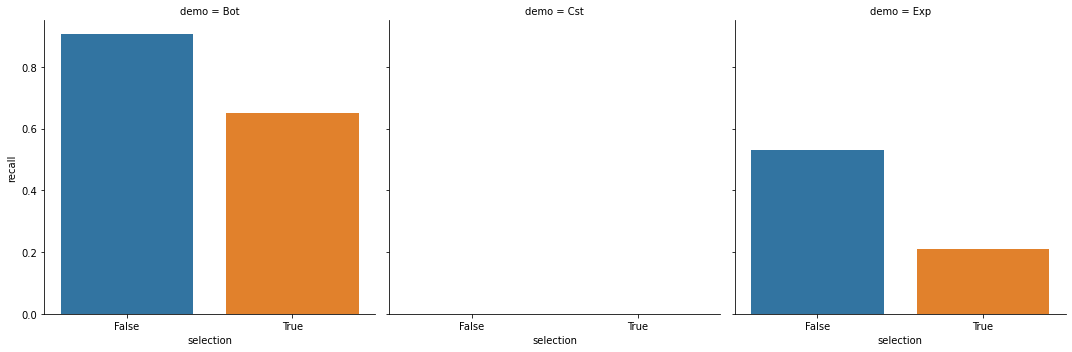

In [130]:
#original data recall
sns.catplot(data=df_recall_tot_ori, y="recall",x="selection", col="demo", kind="bar", legend_out=True)
#plt.savefig('/home/mathieu/Bureau/fig/origrecall.png', transparent=False)

In [132]:
df_rb = dforiginal.groupby(["selection"]).apply(precision_bottle).to_frame("precision").reset_index()
df_rb['demo']='Bot'
df_re = dforiginal.groupby(["selection"]).apply(precision_expan).to_frame("precision").reset_index()
df_re['demo']='Exp'
df_rc = dforiginal.groupby(["selection"]).apply(precision_cst).to_frame("precision").reset_index()
df_rc['demo']='Cst'
df_precision_tot_ori = pd.concat([df_rb, df_rc,df_re],axis=0)
df_precision_tot_ori

selection  precision demo
0      False   0.346154  Bot
1       True   0.234724  Bot
0      False   0.000000  Cst
1       True   0.000000  Cst
0      False   0.751825  Exp
1       True   0.305785  Exp

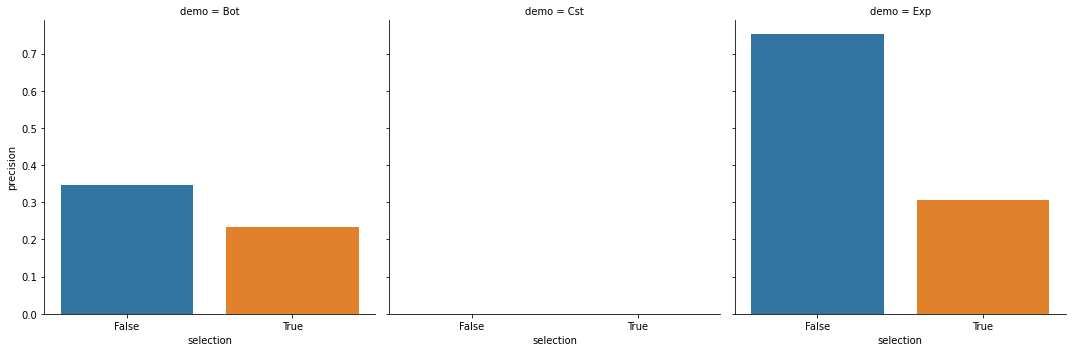

In [133]:
#original data precision
sns.catplot(data=df_precision_tot_ori, y="precision",x="selection", col="demo", kind="bar", legend_out=True)

<h1>DAMAGE<h1>

In [155]:
df_rb = dfres.groupby(["selection","error_rate", "coverage"]).apply(recall_bottle).to_frame("recall").reset_index()
df_rb['demo']='Bot'
df_re = dfres.groupby(["selection","error_rate", "coverage"]).apply(recall_expan).to_frame("recall").reset_index()
df_re['demo']='Exp'
df_rc = dfres.groupby(["selection","error_rate", "coverage"]).apply(recall_cst).to_frame("recall").reset_index()
df_rc['demo']='Cst'

In [156]:
df_recall_tot_damaged = pd.concat([df_rb, df_rc,df_re],axis=0)

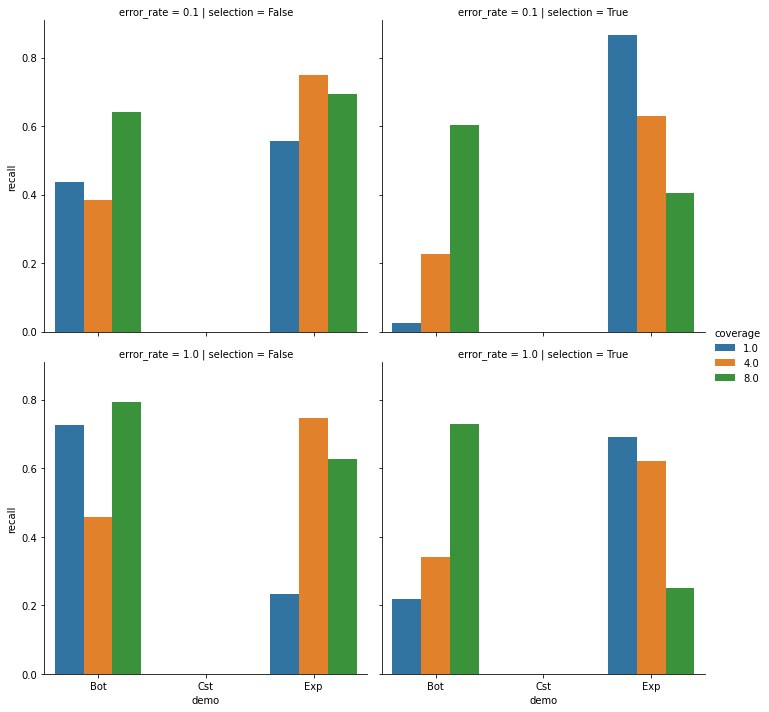

In [158]:
#damaged data recall
chart = sns.catplot(data=df_recall_tot_damaged, y="recall", x="demo", hue="coverage", row="error_rate", col="selection", kind="bar", legend_out=True)

In [153]:
df_rb = dfres.groupby(["selection","error_rate", "coverage"]).apply(precision_bottle).to_frame("precision").reset_index()
df_rb['demo']='Bot'
df_re = dfres.groupby(["selection","error_rate", "coverage"]).apply(precision_expan).to_frame("precision").reset_index()
df_re['demo']='Exp'
df_rc = dfres.groupby(["selection","error_rate", "coverage"]).apply(precision_cst).to_frame("precision").reset_index()
df_rc['demo']='Cst'
df_precision_tot_damaged = pd.concat([df_rb, df_rc,df_re],axis=0)

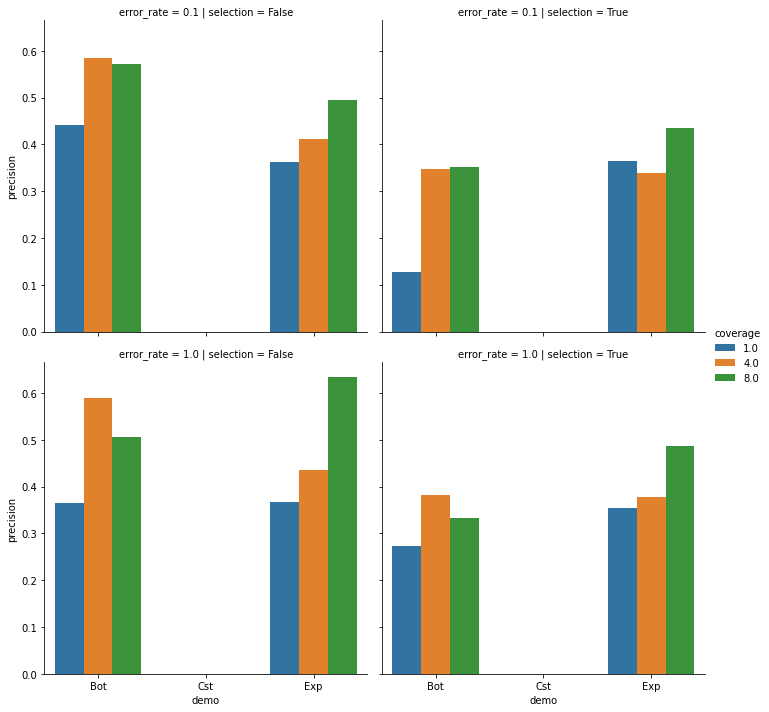

In [154]:
#damaged data precision
sns.catplot(data=df_precision_tot_damaged, y="precision", x="demo", hue="coverage", row="error_rate", col="selection", kind="bar", legend_out=True)

<h1>Validation<h1>

In [1]:
dfvalid = pd.read_csv('/media/mathieu/crucialmx300/skyline/validEvent20.csv', sep=",", header=0)

NameError: name 'pd' is not defined

In [2]:
dfvalid.groupby(["selection", "observed_class"]).expected_class.value_counts().unstack()

NameError: name 'dfvalid' is not defined

In [3]:
pd.crosstab(dfvalid['expected_class'],dfvalid['observed_class'])

NameError: name 'pd' is not defined

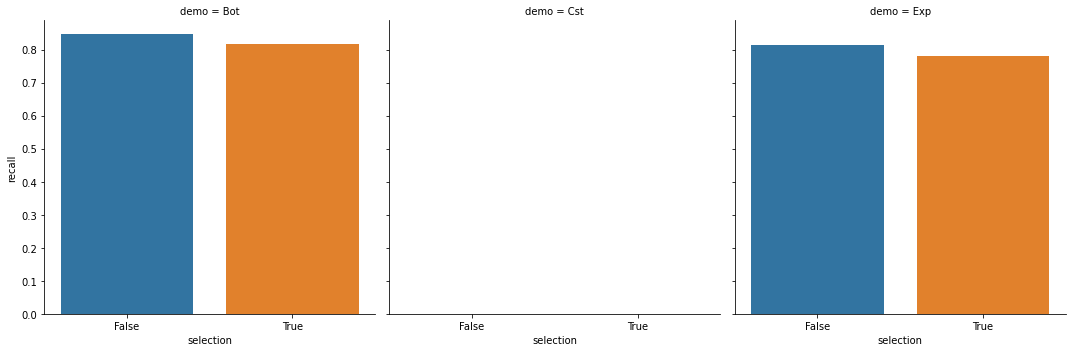

In [135]:

df_rb = dfvalid.groupby(["selection"]).apply(recall_bottle).to_frame("recall").reset_index()
df_rb['demo']='Bot'
df_re = dfvalid.groupby(["selection"]).apply(recall_expan).to_frame("recall").reset_index()
df_re['demo']='Exp'
df_rc = dfvalid.groupby(["selection"]).apply(recall_cst).to_frame("recall").reset_index()
df_rc['demo']='Cst'
df_recall_tot_ori = pd.concat([df_rb, df_rc,df_re],axis=0)
#original data recall
sns.catplot(data=df_recall_tot_ori, y="recall",x="selection", col="demo", kind="bar", legend_out=True)

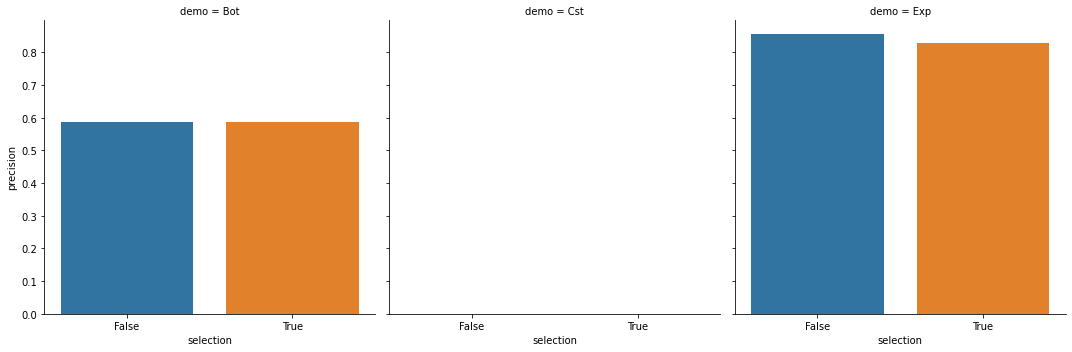

In [136]:
df_rb = dfvalid.groupby(["selection"]).apply(precision_bottle).to_frame("precision").reset_index()
df_rb['demo']='Bot'
df_re = dfvalid.groupby(["selection"]).apply(precision_expan).to_frame("precision").reset_index()
df_re['demo']='Exp'
df_rc = dfvalid.groupby(["selection"]).apply(precision_cst).to_frame("precision").reset_index()
df_rc['demo']='Cst'
df_precision_tot_ori = pd.concat([df_rb, df_rc,df_re],axis=0)
df_precision_tot_ori
#original data precision
sns.catplot(data=df_precision_tot_ori, y="precision",x="selection", col="demo", kind="bar", legend_out=True)

<h1>Beast<h1>

In [85]:
df = pd.read_csv('/media/mathieu/crucialmx300/skyline/beastResult.csv', sep=";", header=0)

In [87]:
import re
df['demo']=''
for i in range(df.shape[0]):
    
    num=re.findall(r'\d+_', df.loc[i,'scenario'])[0][:-1]
    expected_class, demo, selection = compute_expected_class('scenario_'+num)
     
    df.loc[i,'demo']=demo

In [88]:
def percentage(grp):
    return len(grp) / sum(df.demo == grp.demo[0])

dfp = df.groupby(["demo",'variation']).apply(percentage).to_frame("percentage").reset_index()

In [81]:
dfp

demo  variation  percentage
0  Bot   constant    0.701754
1  Bot  variation    0.298246
2  Cst   constant    0.835821
3  Cst  variation    0.164179
4  Exp   constant    0.237288
5  Exp  variation    0.762712

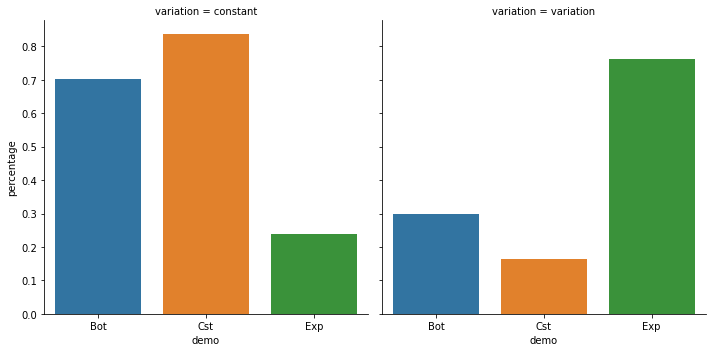

In [89]:
sns.catplot(data=dfp, y="percentage",x="demo", col="variation", kind="bar", legend_out=True)